In [19]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from keras.models import Sequential
from keras.optimizers import Adam
from keras import layers




np.random.seed = 10

In [10]:
EMPRESA = 'ITUB4.SA'

def get_data_ticker(ticker, period='5y'):
    data_hist = yf.download(ticker, period=period)
    data_hist = pd.DataFrame(data_hist['Close'])
    data_hist['prev-day-1'] = data_hist['Close'].rolling(5).mean().shift(1)
    data_hist['prev-day-2'] = data_hist['Close'].rolling(5).mean().shift(2)
    data_hist['prev-day-3'] = data_hist['Close'].rolling(5).mean().shift(3)
    data_hist['mm_5'] = data_hist['Close'].rolling(5).mean()
    data_hist['mm_21'] = data_hist['Close'].rolling(21).mean()
    data_hist = data_hist.dropna()
    data_hist['tomorrow'] = data_hist['Close'].rolling(5).mean().shift(-1)
    return data_hist

df_full = get_data_ticker(EMPRESA, period='5y')
df = df_full.dropna()

[*********************100%***********************]  1 of 1 completed


In [11]:
def split_df_X_y(df_model):
    dates = df_model.index
    df_as_np = df_model.to_numpy()
    X = df_as_np[:,:-1]

    X = X.reshape(len(dates), X.shape[1], 1)
    y = df_as_np[:,-1]

    return (dates, X.astype(np.float32), y.astype(np.float32))

dates, X, y = split_df_X_y(df)

[*********************100%***********************]  1 of 1 completed


[26.9826086  26.98361421 26.98461982 ... 35.28309186 35.30966643
 35.336241  ]
[0.50816318 0.27767881 0.08246907 ... 0.75074047 0.76461762 0.75789063]
[6.77922868 6.59270707 6.34691258 ... 0.70416663 0.70771745 0.73587021]
[34.27000046 33.85400009 33.41400146 ... 36.73799896 36.7820015
 36.83000183]


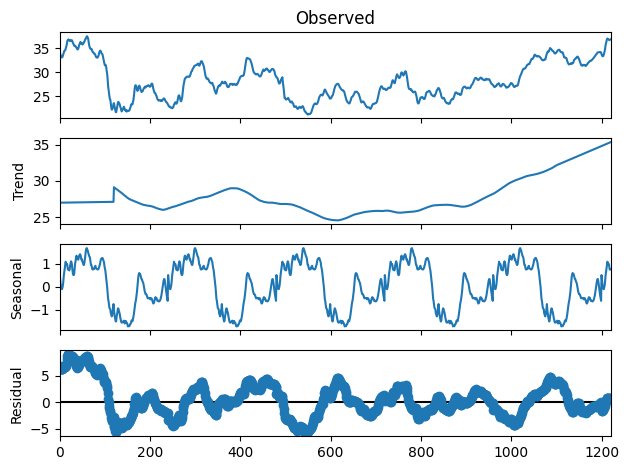

In [43]:
df: pd.DataFrame = get_data_ticker(EMPRESA, period='5y')[['Close']]
df = df.asfreq('1d').fillna(0)
result = seasonal_decompose(y, period=240, extrapolate_trend='freq')

trend = result.trend
seasonal = result.seasonal
residuo = result.resid

print(trend)
print(seasonal)
print(residuo)
print(result.observed)
result.plot()
plt.show()

In [17]:
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

In [23]:
check_stationarity(trend)

The series is NOT stationary


In [24]:
check_stationarity(seasonal)

The series is stationary


# Sarima para Sazonalidade

O result.seasonal já está estacionário, portanto, podemos fazer a aplicação direta do modelo SARIMA

In [55]:
sazonalidade = 240 #Sazonalidade é anual

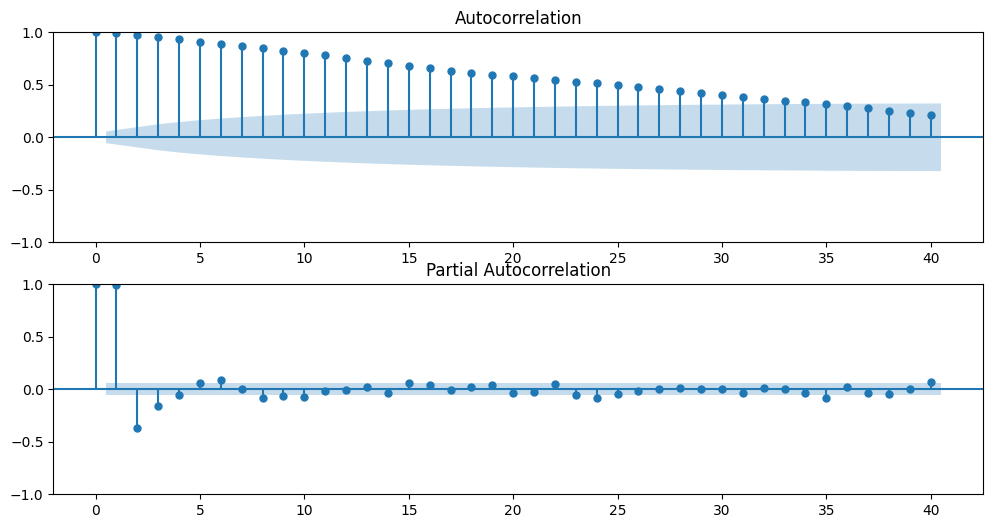

In [56]:
# Plot ACF e PACF para identificar parâmetros não sazonais
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(seasonal, ax=plt.gca(), lags=40)
plt.subplot(212)
plot_pacf(seasonal, ax=plt.gca(), lags=40, method='ywm')
plt.show()

O fato de termos uma autocorrelaçao (ACF) decrescente e uma autocorrelaçao parcial (PACF) truncada indica que temos um AR, o que quer dizer que um termo pode ser previsto a partir dos últimos p termos e que uma média móvel de q termos não é necessária, ou seja q pode ser assumido com 0 ou 1.

No segundo gráfico (PACF) é claro que há o primeiro corte da linha da zona de confiança ocorre após a segunda observação (índice 1), mas como a terceira observaçao é a primeira cortar de baixo para cima podemos dizer que o parâmetro p pode ser 1 ou 2.

In [57]:
# Definir os parâmetros do modelo
p, d, q = 1, 0, 0
P, D, Q, s = 1, 0, 0, sazonalidade

# Ajustar o modelo SARIMA
model = SARIMAX(seasonal, 
                order=(p, d, q), 
                seasonal_order=(P, D, Q, s),
                enforce_stationarity=True,
                enforce_invertibility=True)

model_fit = model.fit(disp=False)
print(model_fit.summary())

/home/luiz/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 1221
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 240)   Log Likelihood                5934.046
Date:                             Mon, 02 Sep 2024   AIC                         -11862.092
Time:                                     01:25:34   BIC                         -11846.769
Sample:                                          0   HQIC                        -11856.325
                                            - 1221                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9919      0.000   2854.901      0.000       0.991       0.993
ar.S.L240      0.9999   6.9

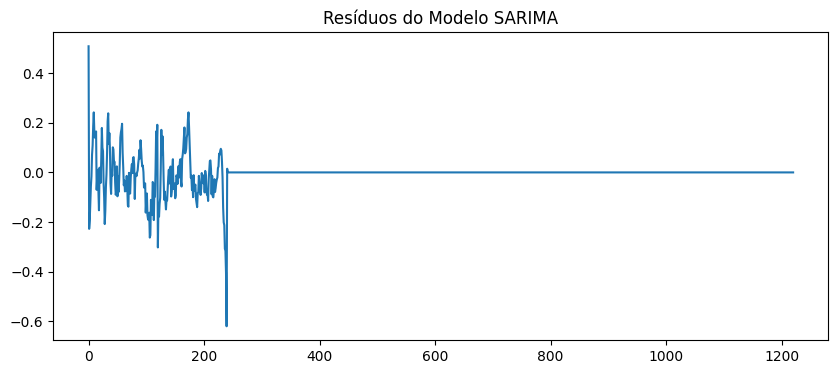

       lb_stat      lb_pvalue
10  926.557269  1.223379e-192


In [58]:
# Resíduos do modelo
residuals = model_fit.resid

# Plot dos resíduos
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Resíduos do Modelo SARIMA')
plt.show()


# Teste de Ljung-Box para verificar autocorrelação nos resíduos
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(lb_test)


/tmp/ipykernel_7599/864152709.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=seasonal[-1], periods=n_steps+1, freq='M')[1:]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

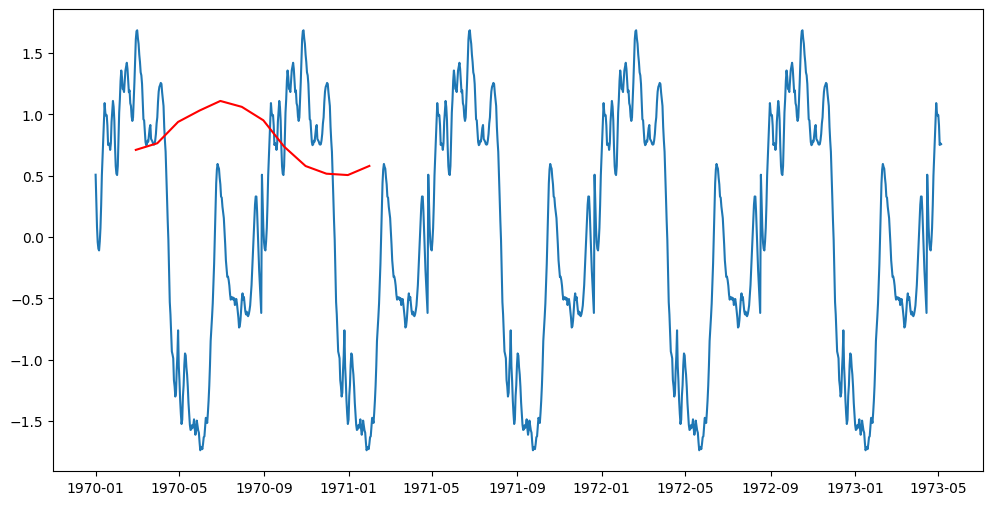

In [62]:
# Número de passos para previsão
n_steps = 12  # Por exemplo, 12 meses à frente

# Fazer previsão
forecast = model_fit.get_forecast(steps=n_steps)
forecast_index = pd.date_range(start=seasonal[-1], periods=n_steps+1, freq='M')[1:]
forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)
conf_int = forecast.conf_int()

# Plotar as previsões
plt.figure(figsize=(12, 6))
plt.plot(seasonal, label='Histórico')
plt.plot(forecast_series, label='Previsão', color='red')
plt.fill_between(forecast_index, 
                 conf_int['lower valor'], 
                 conf_int['upper valor'], 
                 color='pink', alpha=0.3)
plt.title('Previsão com SARIMA')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend()
plt.show()